In [1]:
### **1. Import the Required Libraries**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [4]:
train_dataset_path = '/kaggle/input/fundus-pytorch/train'
validation_dataset_path = '/kaggle/input/fundus-pytorch/val'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
image_size = (128,128)

Loading the training dataset and applying augmentations on it.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    fill_mode='nearest',)
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 8621 images belonging to 2 classes.


Loading the validation dataset.

In [7]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 5747 images belonging to 2 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [8]:
label_mapping = {0: "normal", 1: "glaucoma"}
labels = {label_mapping[value]: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

normal : 0
glaucoma : 1


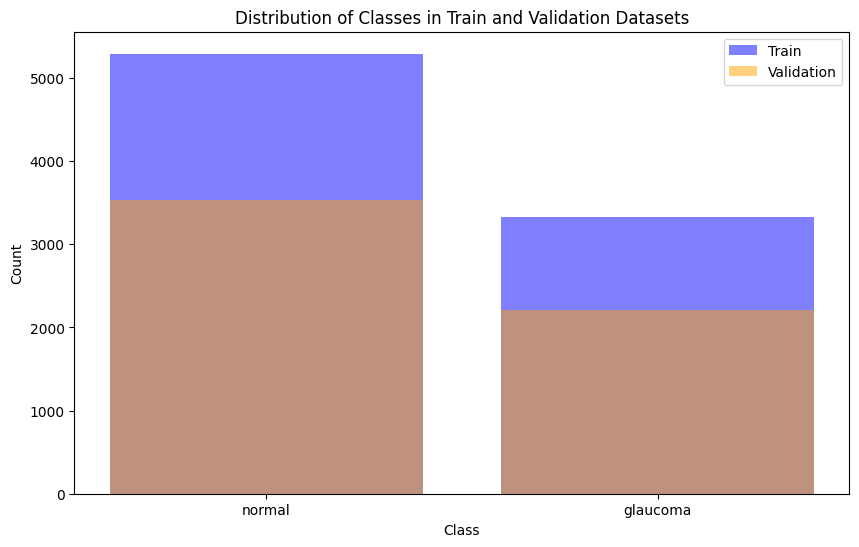

In [9]:
import matplotlib.pyplot as plt

# Get the class indices of the images generated by the train and validation generators
train_class_indices = train_generator.classes
validation_class_indices = validation_generator.classes

# Count the occurrences of each class in the train and validation datasets
train_class_counts = {label_mapping[i]: train_class_indices.tolist().count(i) for i in range(len(label_mapping))}
validation_class_counts = {label_mapping[i]: validation_class_indices.tolist().count(i) for i in range(len(label_mapping))}

# Plot the count of normal and glaucoma images in the train and validation datasets
plt.figure(figsize=(10, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue', alpha=0.5, label='Train')
plt.bar(validation_class_counts.keys(), validation_class_counts.values(), color='orange', alpha=0.5, label='Validation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Train and Validation Datasets')
plt.legend()
plt.show()


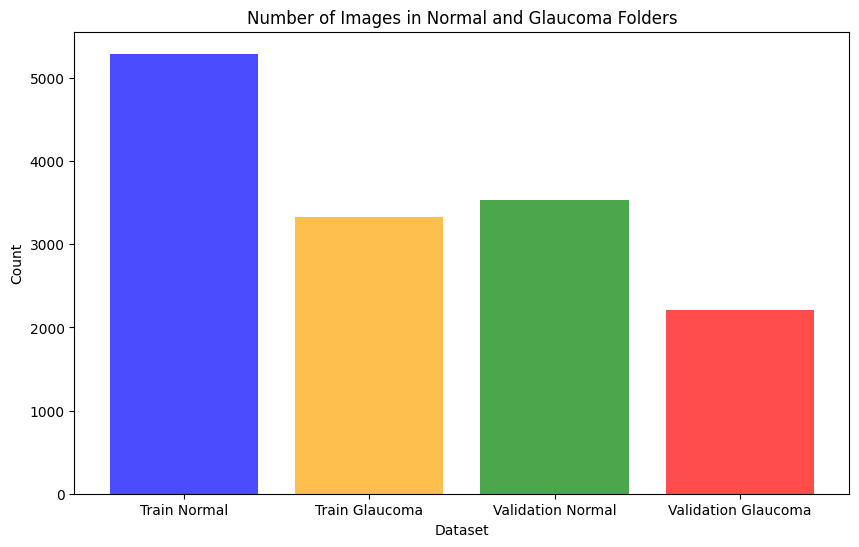

In [10]:
import matplotlib.pyplot as plt

# Extract the class labels (normal or glaucoma) from the filenames of train and validation datasets
train_class_labels = [filename.split('/')[0] for filename in train_generator.filenames]
validation_class_labels = [filename.split('/')[0] for filename in validation_generator.filenames]

# Count the occurrences of each class in the train and validation datasets
train_normal_count = train_class_labels.count('0')
train_glaucoma_count = train_class_labels.count('1')
validation_normal_count = validation_class_labels.count('0')
validation_glaucoma_count = validation_class_labels.count('1')

# Plot the count of normal and glaucoma images in the train and validation datasets
labels = ['Train Normal', 'Train Glaucoma', 'Validation Normal', 'Validation Glaucoma']
counts = [train_normal_count, train_glaucoma_count, validation_normal_count, validation_glaucoma_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.title('Number of Images in Normal and Glaucoma Folders')
plt.show()


### **3. Plotting Sample Training Images**

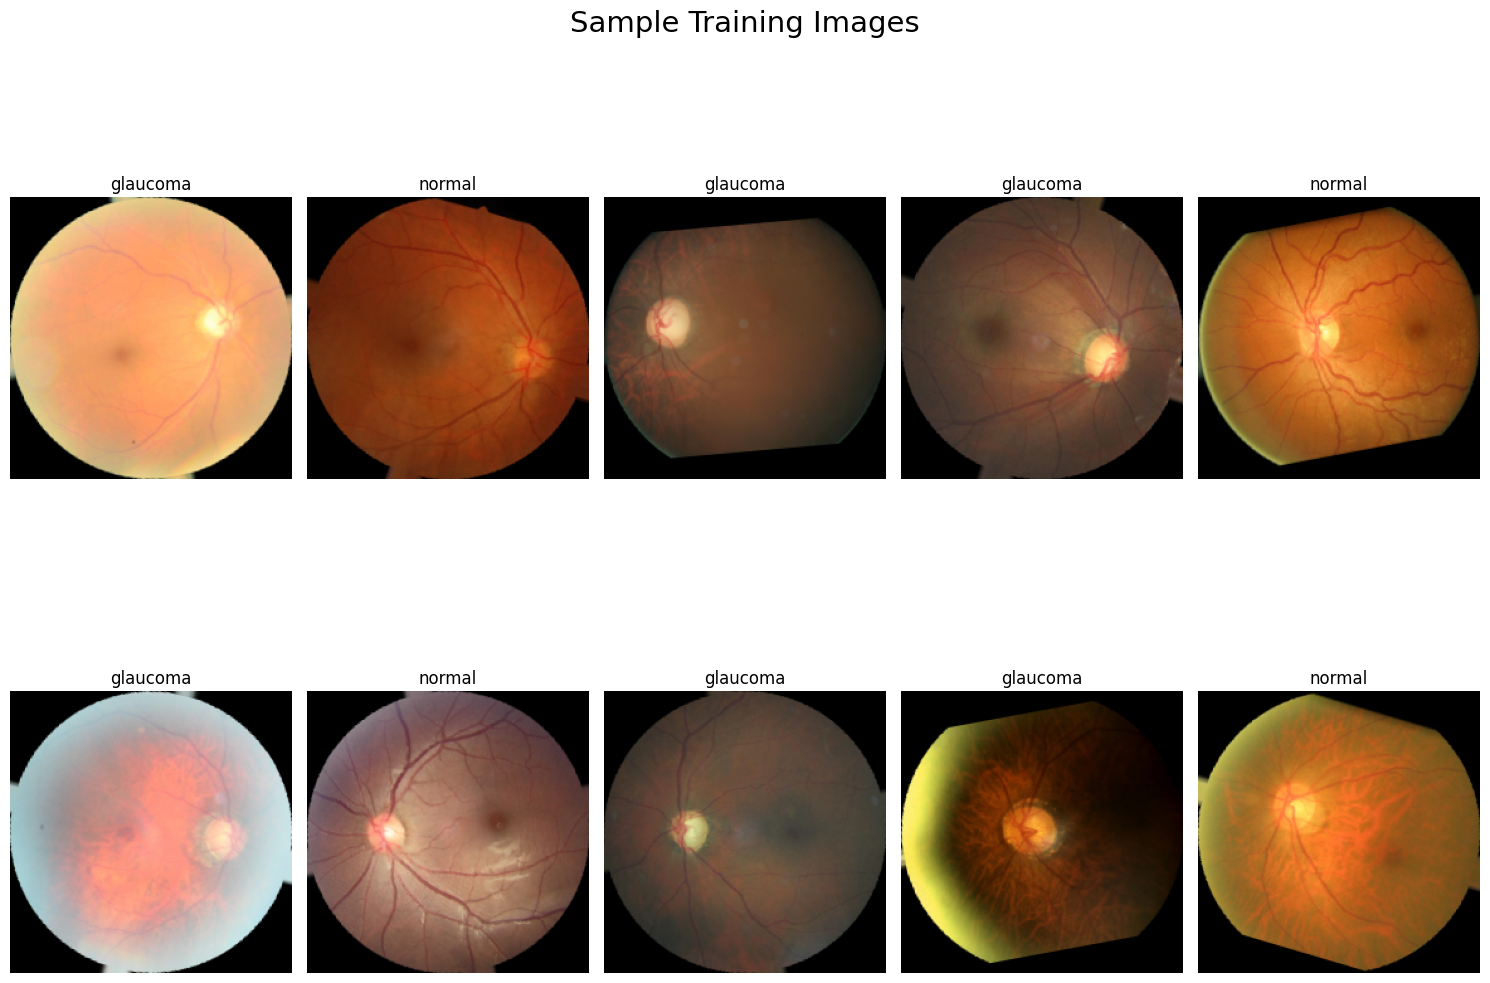

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label_index = np.argmax(train_generator[0][1][idx])
        label = label_mapping[label_index]  # Map the class index to the corresponding label using label_mapping
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i.Create a Xception Build Model**

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.applications.xception import Xception, preprocess_input

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

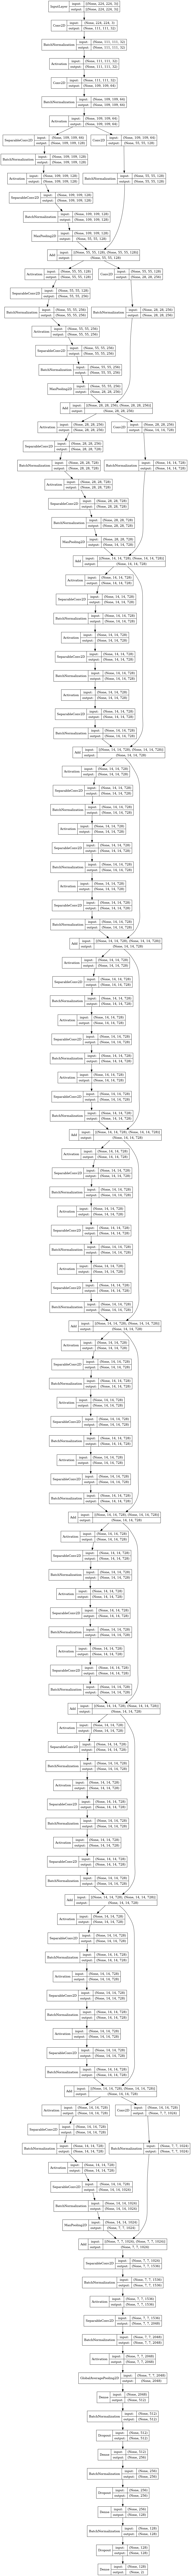

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)

#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [16]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [17]:
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [18]:
# training
history = model.fit(train_generator,batch_size=32,epochs=50,
        validation_data=validation_generator,verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
270/270 - 332s - loss: 0.7359 - accuracy: 0.6716 - val_loss: 0.4621 - val_accuracy: 0.7811 - lr: 0.0010 - 332s/epoch - 1s/step
Epoch 2/50
270/270 - 230s - loss: 0.5296 - accuracy: 0.7497 - val_loss: 0.4794 - val_accuracy: 0.7740 - lr: 0.0010 - 230s/epoch - 853ms/step
Epoch 3/50
270/270 - 239s - loss: 0.4839 - accuracy: 0.7774 - val_loss: 0.4388 - val_accuracy: 0.7954 - lr: 0.0010 - 239s/epoch - 885ms/step
Epoch 4/50
270/270 - 248s - loss: 0.4669 - accuracy: 0.7874 - val_loss: 0.4279 - val_accuracy: 0.8029 - lr: 0.0010 - 248s/epoch - 918ms/step
Epoch 5/50
270/270 - 246s - loss: 0.4620 - accuracy: 0.7890 - val_loss: 0.4102 - val_accuracy: 0.8143 - lr: 0.0010 - 246s/epoch - 910ms/step
Epoch 6/50
270/270 - 240s - loss: 0.4535 - accuracy: 0.7929 - val_loss: 0.4167 - val_accuracy: 0.8095 - lr: 0.0010 - 240s/epoch - 891ms/step
Epoch 7/50
270/270 - 247s - loss: 0.4495 - accuracy: 0.7993 - val_loss: 0.4055 - val_accuracy: 0.8197 - lr: 0.0010 - 247s/epoch - 914ms/step
Epoch 8/50
270/2

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [19]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

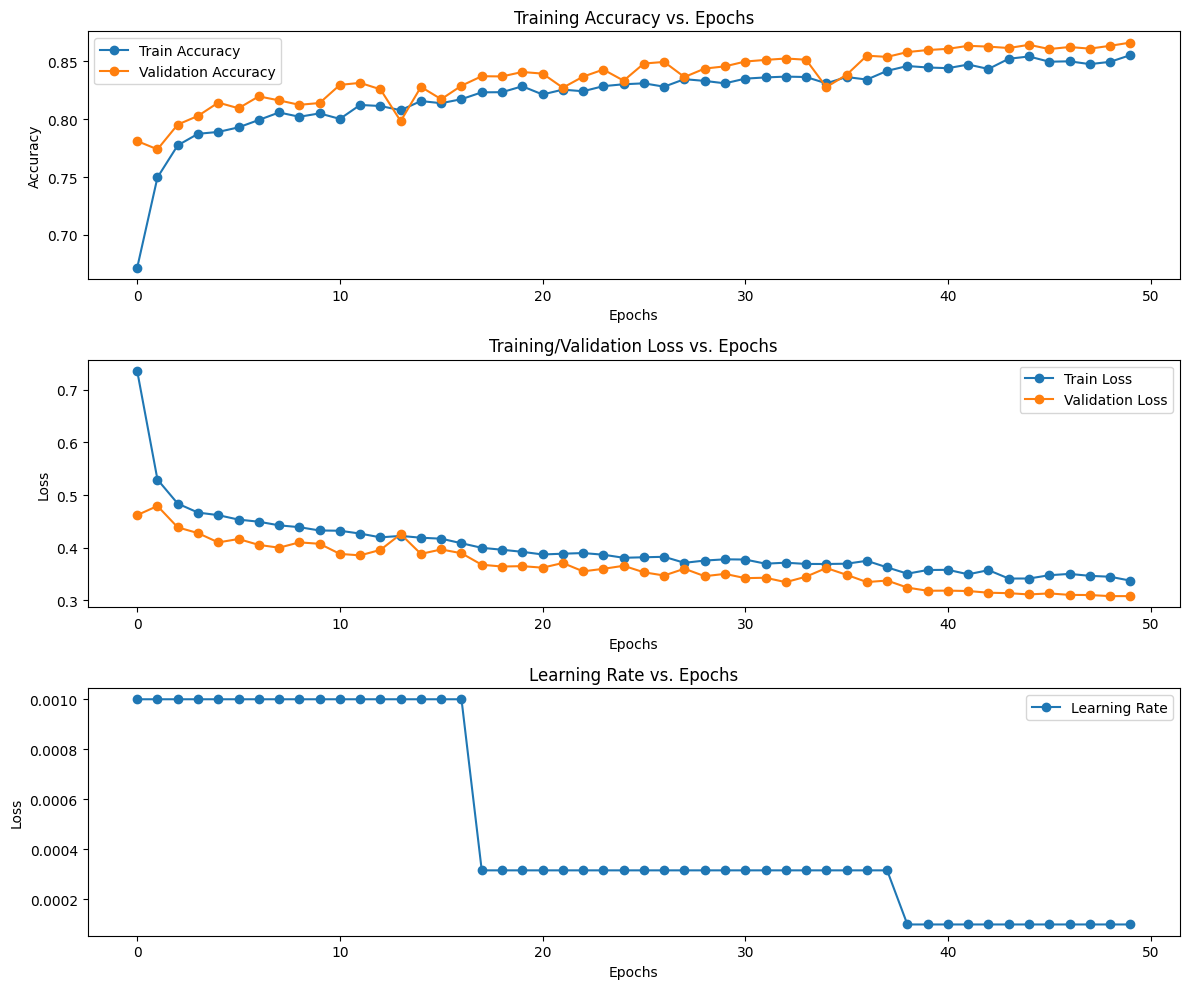

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [21]:
test_dataset = '/kaggle/input/fundus-pytorch/test'

In [22]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 2874 images belonging to 2 classes.


### **7. Model Prediction on the Test Dataset**

In [23]:
predictions = model.predict(test_generator)


90/90 [==============================] - 54s 595ms/step


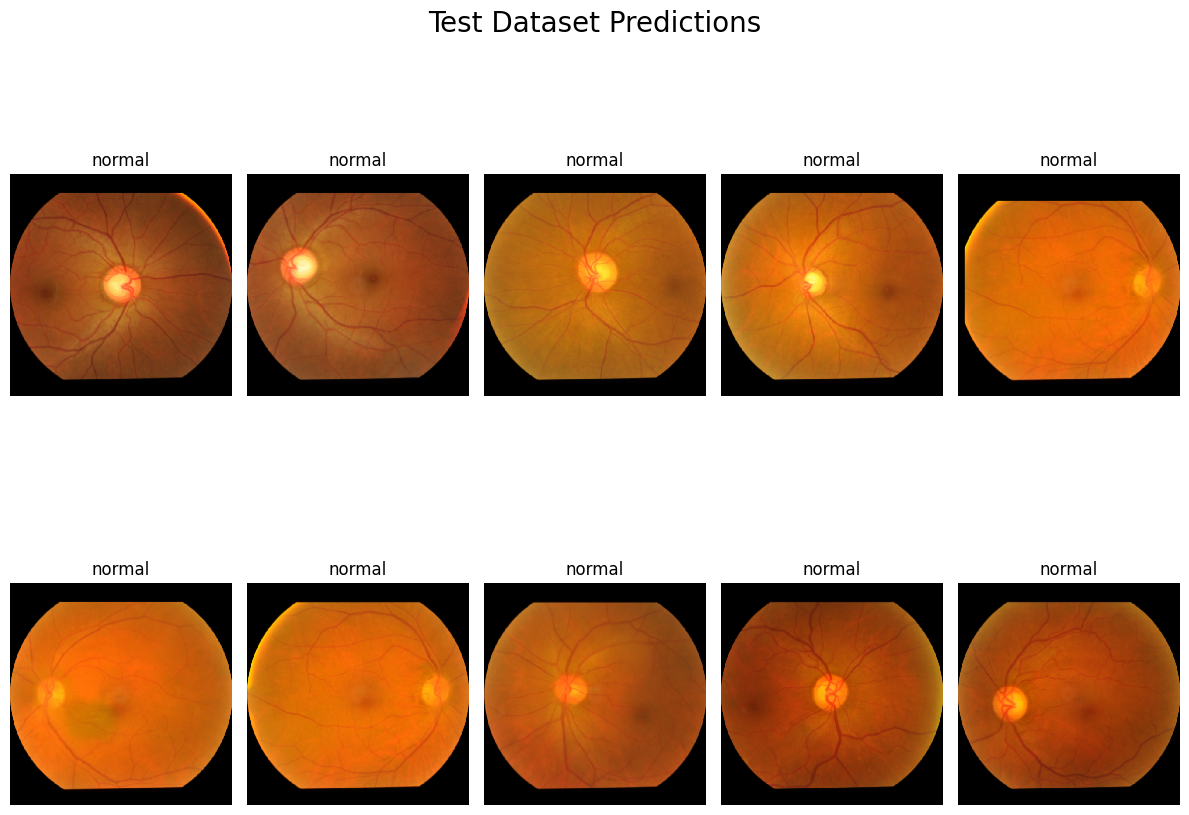

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = np.argmax(predictions[idx])
        labels = {label_mapping[value]: key for key, value in test_generator.class_indices.items()}
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

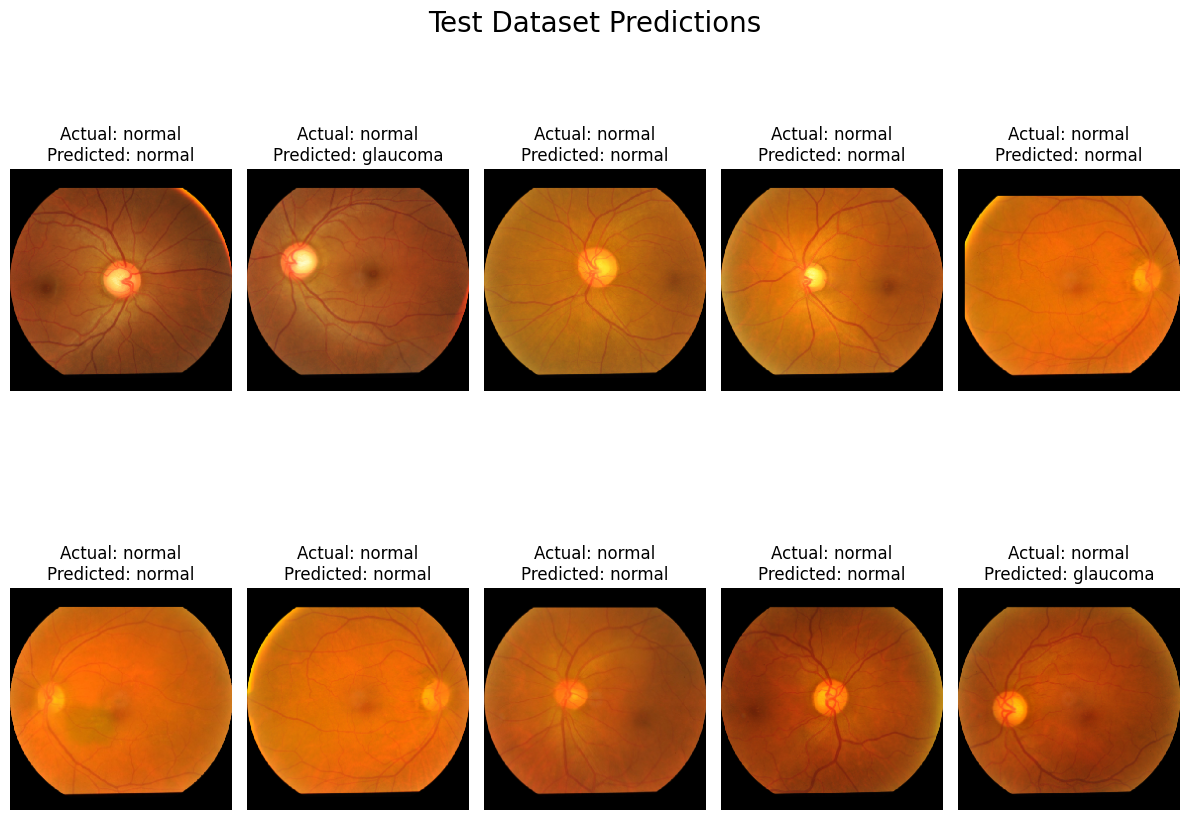

In [25]:
# Define labels as a dictionary with class labels as keys
labels = {label_mapping[value]: key for key, value in test_generator.class_indices.items()}

# Plot the images along with their actual and predicted labels
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        # Extract the predicted label index from the predictions
        predicted_label_index = np.argmax(predictions[idx])
        
        # Get the corresponding label from the dictionary of labels
        predicted_label = list(labels.keys())[predicted_label_index]
        
        # Get the actual label from the generator
        actual_label_index = np.argmax(test_generator[0][1][idx])
        actual_label = list(labels.keys())[actual_label_index]
        
        # Display the actual and predicted labels
        ax[i, j].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        
        # Display the image
        ax[i, j].imshow(test_generator[0][0][idx])
        
        # Turn off axis
        ax[i, j].axis("off")
        
        # Move to the next image index
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


In [26]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)


90/90 [==============================] - 30s 332ms/step - loss: 0.3137 - accuracy: 0.8650


In [27]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.31365060806274414
Test Accuracy: 0.8649964928627014


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [28]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

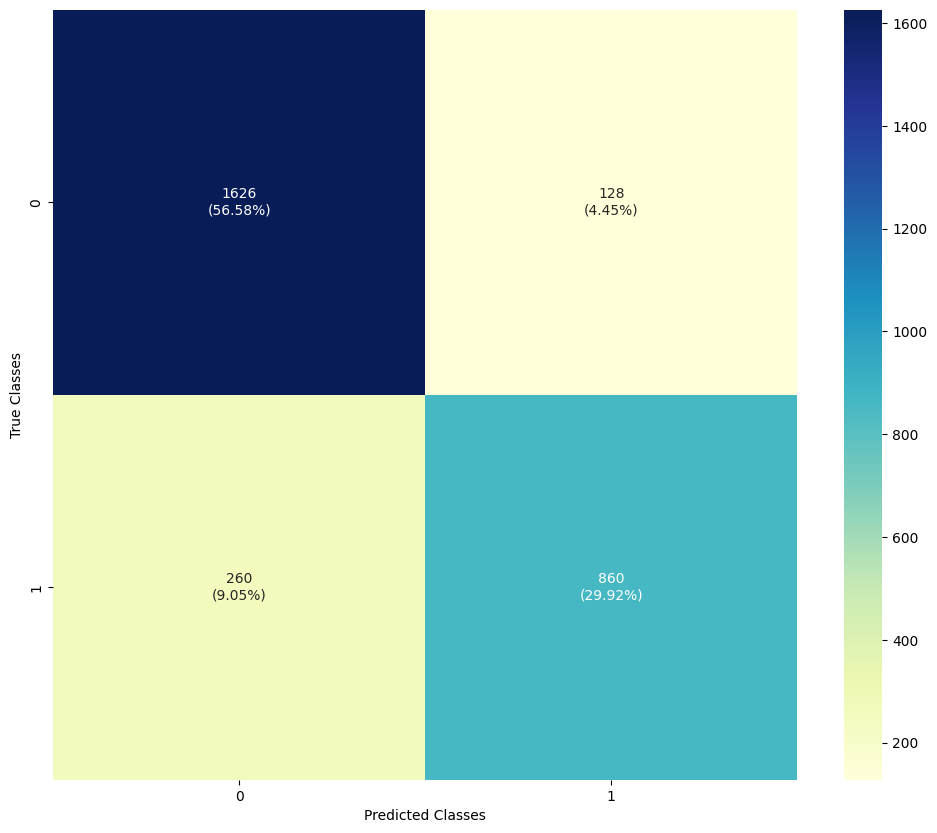

In [29]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1754
           1       0.87      0.77      0.82      1120

    accuracy                           0.86      2874
   macro avg       0.87      0.85      0.85      2874
weighted avg       0.87      0.86      0.86      2874



Grad-CAM

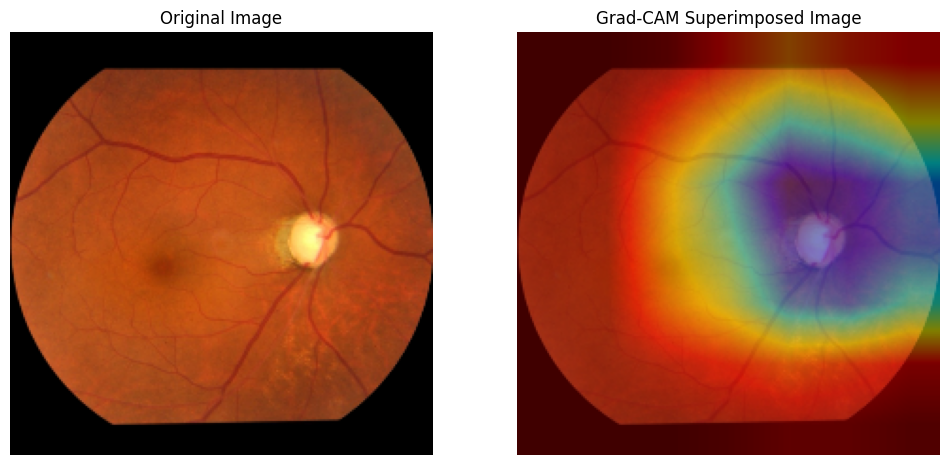

In [31]:
import tensorflow as tf
import numpy as np
import cv2

def get_grad_cam(model, img_array, layer_name, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

    return cam

import matplotlib.pyplot as plt

def apply_grad_cam_with_original(model, img_path, layer_name, class_index):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
    img = preprocess_input(img)
    img_array = np.expand_dims(img, axis=0)

    # Generate Grad-CAM heatmap
    cam = get_grad_cam(model, img_array, layer_name, class_index)
    cam = np.maximum(cam, 0)  # ReLU on the CAM
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # Normalize the CAM
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = (cam * 255).astype(np.uint8)

    # Apply the heatmap on the original image
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, 0.5, img_original, 0.5, 0)

    # Plot both original and superimposed images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title('Grad-CAM Superimposed Image')
    axes[1].axis('off')

    plt.show()

# Example usage
img_path = "/kaggle/input/fundus-pytorch/test/1/BEH-1.png"
layer_name = "block14_sepconv2_act"
class_index = 1  # Index of the class for which Grad-CAM will be applied

apply_grad_cam_with_original(model, img_path, layer_name, class_index)


### **9. Wrong Predictions**

Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [32]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [33]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

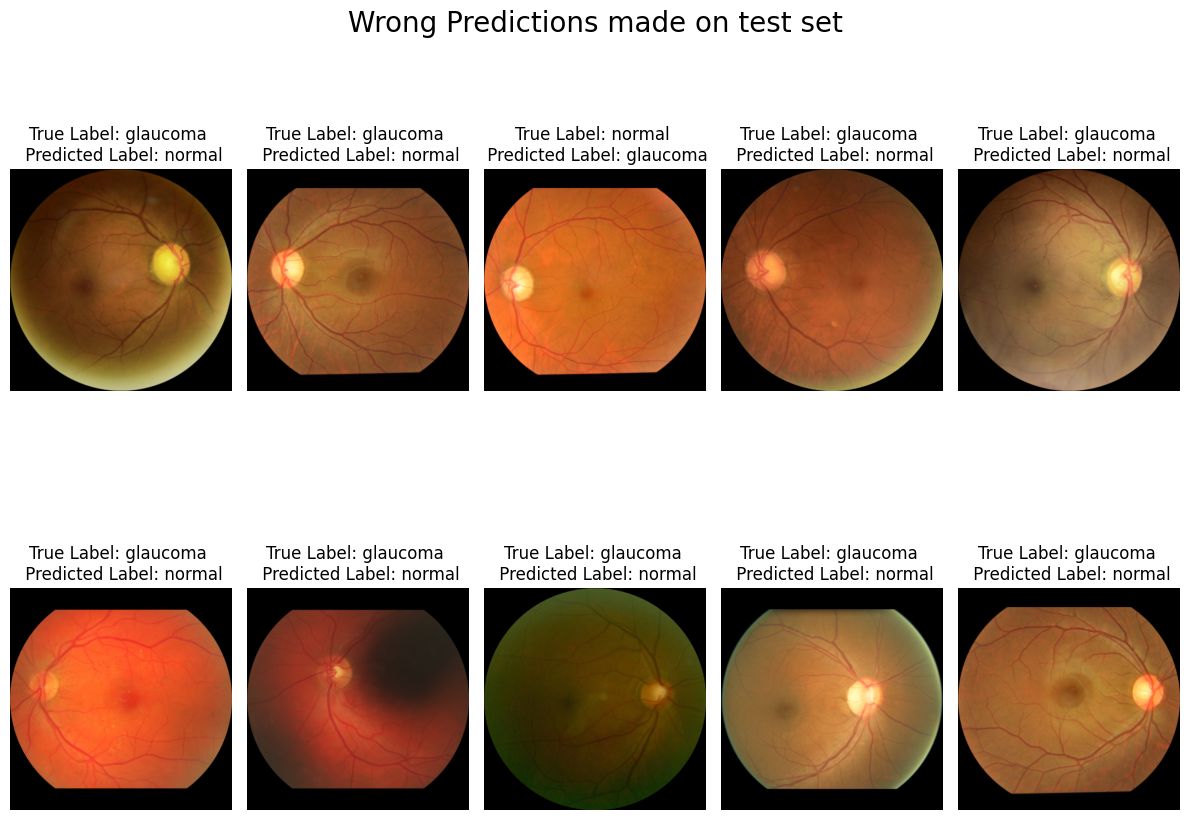

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = true_index
        label_1 = list(labels.keys())[true_label]
        predicted_index = y_pred_errors[idx]
        predicted_label = list(labels.keys())[predicted_index]
        ax[i, j].set_title(f"True Label: {label_1} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()